In [1]:
--miscellaneous imports
require 'torch'
require 'nn'
require 'nngraph'
require 'image'
require 'cutorch'
require 'cunn'
require 'lfs'
require 'image'

modelPath = paths.concat(lfs.currentdir(), 'bestmodels/filt=5-hidden1=5-hidden2=15-hidden3=15-fc1=150-fc2=150/model#180.net')
    --'bestmodels/filt=5-hidden1=5-hidden2=15-hidden3=5-fc1=300-fc2=150/model#150.net')

In [2]:
--load the model
model = torch.load(modelPath)

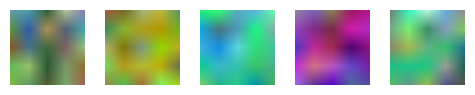

In [28]:
--visualize the first layer kernels
conv1 = model:get(1)
weights = conv1.weight
images = {}

for index = 1, weights:size(1) do
    kernel = weights[index]
    kernel:resize(3,5,5)
    kernel = kernel:double()
    images[index] = image.scale(kernel, 75, 75)
end

itorch.image(images, {nrow = 6, padding = 20})


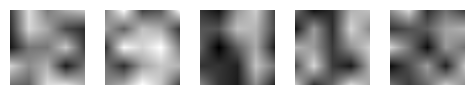

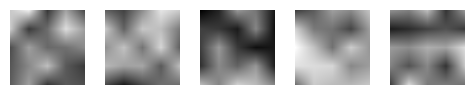

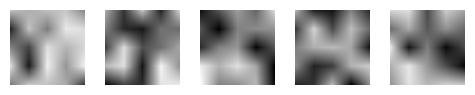

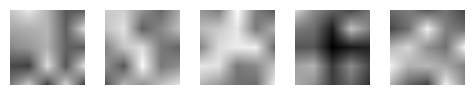

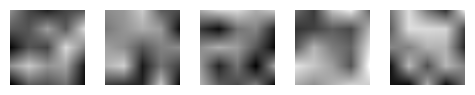

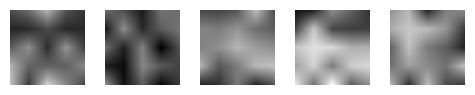

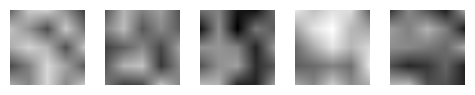

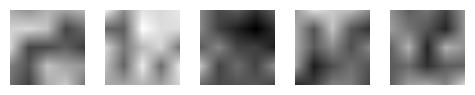

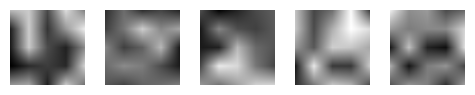

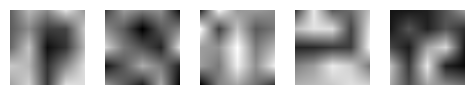

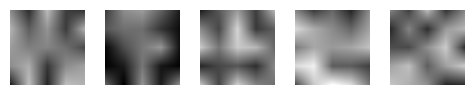

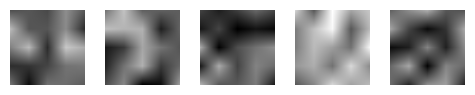

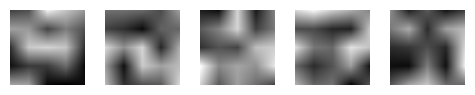

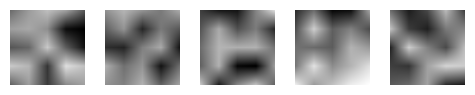

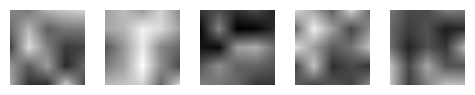

In [25]:
--visualize the first layer kernels
conv2 = model:get(3)
--print(conv2)
weights = conv2.weight

for index = 1, weights:size(1) do
    kernel = weights[index]
    kernel:resize(5, 5, 5)
    images = {}
    
    for weightIndex = 1, kernel:size(1) do
        individualKernel = kernel[weightIndex]
        individualKernel = individualKernel:double()
        images[weightIndex] = image.scale(individualKernel, 75, 75)
        --print(images[weightIndex]:size())
    end
    itorch.image(images, {nrow = 6, padding = 20})
end



[TRACE 11:27:52] 1_data.lua:29: ==> processing options	
[TRACE 11:27:52] 1_data.lua:42: ==> loading dataset	


[TRACE 11:28:00] 1_data.lua:218: ==> visualizing data	


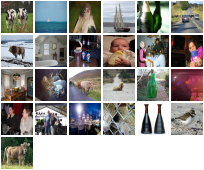

In [4]:
--visualize the output of layers
dofile '1_data.lua'

In [5]:
classes = {
    [1] = 'cow',
    [2] = 'boat',
    [3] = 'sheep',
    [4] = 'bottle',
    [5] = 'bird',    
}
function getClassName(number)
    return classes[number]
end

In [6]:
dofile 'utilities.lua'

function getSampleImagesForClasses(samples, labels)
    sampleImages = {}
    rawImages = {}
    
    for index = 1, samples:size(1) do
        --assign emptz table if key doesn't exists
        name = getClassName(labels[index])
        if(sampleImages[name] == nil) then
            sampleImages[name] = {}
            rawImages[name] = {}
        end
        
        allKeys = table.getAllKeys(sampleImages[name])
        if(#allKeys <= 20) then
            table.insert(sampleImages[name], image.scale(samples[index], 60, 60))
            table.insert(rawImages[name], samples[index])
        end
    end
    
    return sampleImages, rawImages
end


bird	


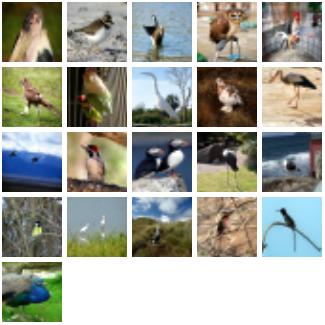

boat	


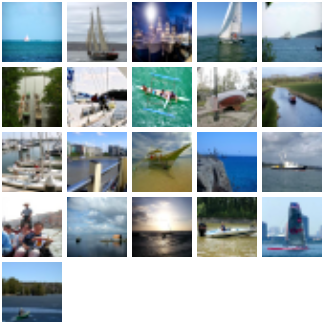

sheep	


bottle	

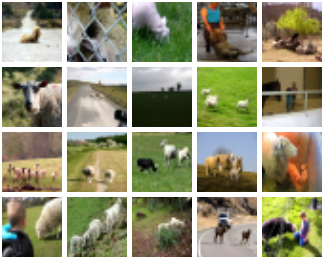

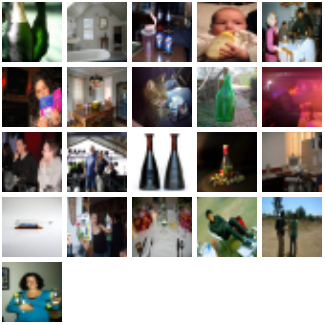

cow	


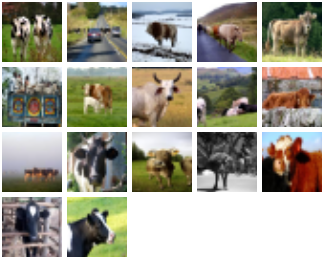

In [7]:
first50Samples = trainData.data[{ {1,150},{} }]
labels = trainData.labels[{ {1,150}}]

sampleImages, rawImages = getSampleImagesForClasses(first50Samples, labels)

for k, v in pairs(sampleImages) do
    print(k)
    itorch.image(sampleImages[k] , {nrow=5, padding = 5, zoom=5, scaleeach=5})
end
    

In [8]:
--forward the input for each of the classes and print the layer outputs
function saveLayerOutputs(className, samples, index)
    imageInstance = samples[className][index]
    imageInstance = imageInstance:cuda()
    pred = model:forward(imageInstance)
    print(className)
    itorch.image(imageInstance)
    
    convLayers = {1, 3, 5}

    for k, v in ipairs(convLayers) do
        print('convolution layer ' .. k)
        conv = model:get(v)
        
        outputBuffer = {}

        for index = 1, conv.output:size(1) do
            currOutput = conv.output[index]:double()
            currOutput = image.scale(currOutput, 50, 50)
            currOutput:resize(1, currOutput:size(1), currOutput:size(2))
            currOutput = (currOutput - currOutput:min()) * 100
            table.insert(outputBuffer, image.y2jet(currOutput + 1))
        end
        
        itorch.image(outputBuffer, {nrow = 10, padding = 5})        
    end
end

cow	


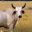

convolution layer 1	


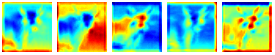

convolution layer 2	


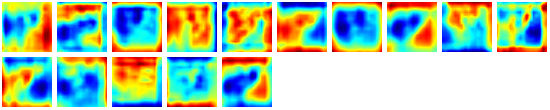

convolution layer 3	


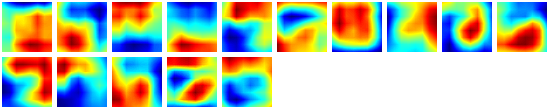

In [9]:
saveLayerOutputs('cow', rawImages, 8)

boat	


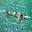

convolution layer 1	


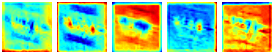

convolution layer 2	


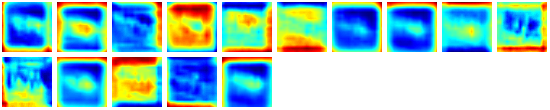

convolution layer 3	


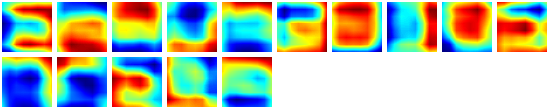

In [10]:
saveLayerOutputs('boat', rawImages, 8)

sheep	


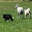

convolution layer 1	


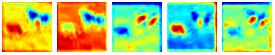

convolution layer 2	


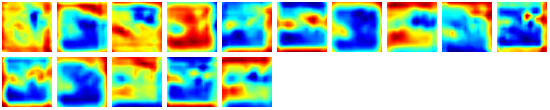

convolution layer 3	


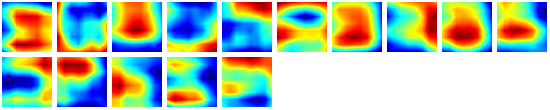

In [11]:
saveLayerOutputs('sheep', rawImages, 13)

bottle	


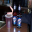

convolution layer 1	


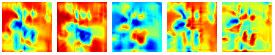

convolution layer 2	


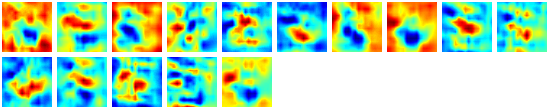

convolution layer 3	


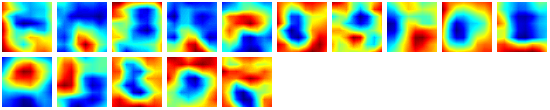

In [12]:
saveLayerOutputs('bottle', rawImages, 3)

bird	


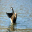

convolution layer 1	


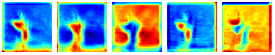

convolution layer 2	


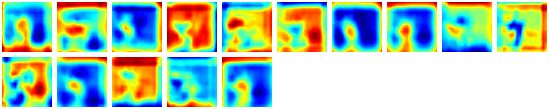

convolution layer 3	


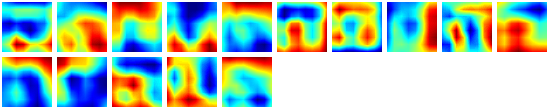

In [17]:
saveLayerOutputs('bird', rawImages, 3)

In [14]:
function collectMisclassifiedImages(actualLabels, predictedLabels, imgs)
    misclassifiedImgs = {}
    count = 1;
    
    for index = 1, imgs:size(1) do
        if(actualLabels[index] ~= predictedLabels[index]) then
            actualClass = getClassName(actualLabels[index])
            predictedClass = getClassName(predictedLabels[index])
            
            if(misclassifiedImgs[actualClass] == nil) then
                misclassifiedImgs[actualClass] = {}
            end
            
            if(misclassifiedImgs[actualClass][predictedClass] == nil) then
                misclassifiedImgs[actualClass][predictedClass] = {}
            end   
            
            table.insert(misclassifiedImgs[actualClass][predictedClass], imgs[index])
        end
    end
    
    return misclassifiedImgs
end

In [15]:
--get the wrong-predicted images
dofile '6_test.lua'
--dofile '5_validate.lua'
require 'optim'
dofile 'utilities.lua'

confusion = optim.ConfusionMatrix(classes)

--validationData.data = validationData.data:cuda()
--validate()

testData.data = testData.data:cuda()
predictedLabels = test()

misclassifiedImgs = collectMisclassifiedImages(testData.labels, predictedLabels, testData.data)


[TRACE 11:28:02] 6_test.lua:14: ==> defining test procedure	


[TRACE 11:28:02] 6_test.lua:31: ==> testing on test set:	
Progress: 1 / 331	


[TRACE 11:28:02] 6_test.lua:54: 
==> time to test 1 sample = 0.28115096769304ms	
[TRACE 11:28:02] 6_test.lua:57: ConfusionMatrix:
[[      12       5       2       7      12]   31.579% 	[class: cow]
 [       2      29       0       6      26]   46.032% 	[class: boat]
 [      11       6       5       7      11]   12.500% 	[class: sheep]
 [       2       9       0      71      13]   74.737% 	[class: bottle]
 [       4      12       2      30      47]]  49.474% 	[class: bird]
 + average row correct: 42.864243388176% 
 + average rowUcol correct (VOC measure): 28.368881195784% 
 + global correct: 49.546827794562%	


In [16]:
picsFolder = '/media/arul/envision/jan-may-2016/kernelmethods/Assignment-2/report/pics/'

--display misclassified images
for actualClass,v in pairs(misclassifiedImgs) do
    --k is actual class name, v is a table of images with key as 'predicted class'
    for predictedClass, imgs in pairs(v) do
        fileName = 'miscallssify_' .. actualClass .. '_to_' .. predictedClass .. '.png'
        currImage = image.toDisplayTensor({input=imgs, nrow = 6, padding = 5, zoom=100})
        image.save(picsFolder .. fileName, currImage)
    end
end